####Pablo Moreno Gonzalez - 100451061

####Ignacio Leal Sánchez - 100495680

#### Grupo 6 - 81

https://github.com/100451061/proyecto_aprendizaje_automatico.git

El cuaderno de la práctica 2 ,clustering.ipynb, está dentro del directorio notebooks.

### Instalación de librerías necesarias
Si no tienes instaladas las librerías requeridas para este notebook, ejecuta la siguiente celda:


In [26]:
%pip install matplotlib seaborn scikit-learn pandas

O bien:

In [27]:
import sys
!{sys.executable} -m pip install pandas matplotlib seaborn scikit-learn

## 1. Comparación visual de escaladores con PCA

En esta primera parte, queremos observar cómo afectan tres métodos de escalado diferentes (`StandardScaler`, `MinMaxScaler` y `RobustScaler`) a la forma en la que se distribuyen los datos cuando los reducimos a 2 dimensiones usando PCA.

Aunque el objetivo final es hacer clustering, primero necesitamos transformar los datos para que las variables estén en una escala comparable. Esto nos ayuda a evitar que algunas características dominen a otras simplemente por tener valores más grandes.

Vamos a usar una `pipeline` que aplica el escalado y luego el PCA. Finalmente, representamos los datos en un gráfico para comparar los resultados.


In [28]:
# importamos librerias necesarias
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
import scipy.cluster.hierarchy as sch
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [29]:
# Cargar el dataset de semillas
df = pd.read_csv('/content/semillas.csv')

# Separar atributos (X) y clase (y)
X = df.drop(columns=['clase']).values
y = df['clase'].values  # Solo para colorear el gráfico (NO usar en clustering)

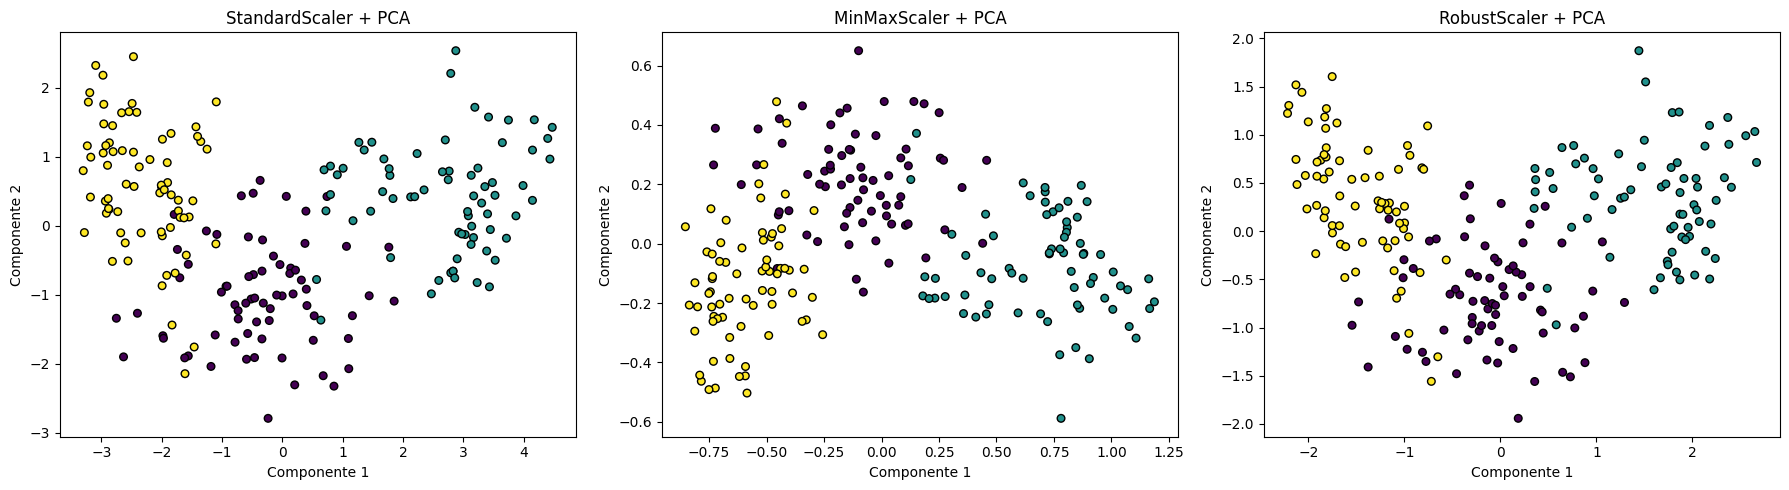

In [30]:
# Diccionario que contiene los diferentes tipos de escaladores que vamos a utilizar
# StandardScaler: Estandariza las características restando la media y escalando a varianza unitaria
# MinMaxScaler: Escala las características al rango [0,1]
# RobustScaler: Escala usando estadísticas robustas a valores atípicos
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

# Crear una figura con un tamaño específico para mostrar los tres gráficos
plt.figure(figsize=(18, 5))

# Iterar sobre cada escalador para crear un gráfico para cada uno
for i, (name, scaler) in enumerate(scalers.items()):
    # Crear un pipeline que combina el escalado de datos y la reducción de dimensionalidad
    # El pipeline primero escala los datos y luego aplica PCA para reducir a 2 dimensiones
    pipeline = Pipeline([
        ('scaler', scaler),
        ('pca', PCA(n_components=2))
    ])

    # Aplicar la transformación completa a los datos
    # Esto escala los datos y luego aplica PCA para obtener las dos componentes principales
    X_pca = pipeline.fit_transform(X)

    # Crear un subgráfico para cada escalador
    plt.subplot(1, 3, i+1)
    # Crear un gráfico de dispersión donde:
    # - X_pca[:, 0] son los valores de la primera componente principal
    # - X_pca[:, 1] son los valores de la segunda componente principal
    # - c=y colorea los puntos según la variable objetivo
    # - cmap='viridis' define la paleta de colores
    # - edgecolor='k' establece el borde de los puntos en negro
    # - s=30 define el tamaño de los puntos
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k', s=30)
    plt.title(f'{name} + PCA')
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')

# Ajustar el diseño para evitar superposición de subgráficosy mostrar la figura completa
plt.tight_layout()
plt.show()

### Comparación visual de escaladores

En estos gráficos vemos cómo cambia la forma en que se reparten los datos cuando usamos diferentes formas de escalarlos antes de aplicar PCA. Aunque los colores indican la clase original de cada semilla, no se han usado para entrenar nada. Solo los mostramos para tener una referencia visual.

Lo que buscamos aquí es ver si los datos se separan de forma más clara con algún escalador en particular. En mi caso, el que parece funcionar mejor es StandardScaler, ya que los grupos se distinguen mejor visualmente, sin tanto solapamiento entre ellos.

- **StandardScaler + PCA:**  
  Esta transformación parece ser la que mejor separa visualmente los grupos. Los puntos se distribuyen bastante bien a lo largo de los dos componentes principales, y se distinguen tres zonas bastante definidas, lo que puede facilitar la tarea de clustering. Además, los datos se ven más centrados y simétricos, sin demasiada compresión ni distorsión.

- **MinMaxScaler + PCA:**  
  En este caso, los puntos están más apretados y la escala de los ejes es muy pequeña (entre -1 y 1). Aunque se siguen viendo agrupaciones, los grupos están más solapados. Esto podría dificultar que los algoritmos de clustering detecten bien las fronteras. Es un escalado útil en algunos casos, pero aquí parece menos efectivo.

- **RobustScaler + PCA:**  
  Esta opción también ofrece una separación razonable. Funciona especialmente bien cuando hay valores extremos (outliers), ya que usa la mediana y los cuartiles para escalar. En este ejemplo concreto, los datos se ven más dispersos que con MinMax, y las agrupaciones son más claras, aunque algo menos que con StandardScaler.

Esta observación es importante porque nos puede ayudar a elegir el mejor preprocesamiento antes de pasar a hacer clustering en la siguiente parte.

Ahora vamos a elegir uno de esos escaladores, en este caso StandardScaler, (porque se ve que separa mejor los grupos) y aplicar los algoritmos de clustering sobre esa versión de los datos.

Empezamos por el primero: K-Means.

PASO 1: Aplicar StandardScaler + PCA y guardar los datos para clustering


In [31]:
# Usamos StandardScaler, que fue el más claro visualmente
scaler_final = StandardScaler()
X_scaled = scaler_final.fit_transform(X)

pca_final = PCA(n_components=2)
X_pca_std = pca_final.fit_transform(X_scaled)

PASO 2: Elegir cuántos clusters usar con el método del codo

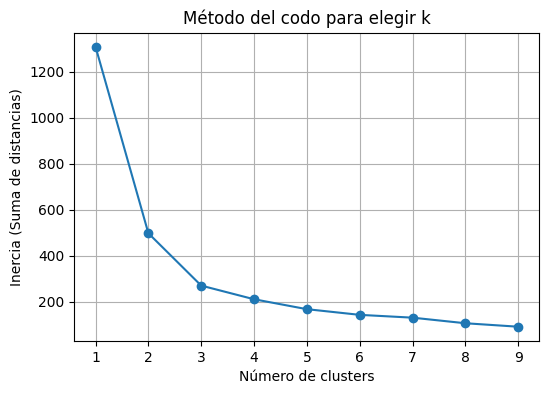

In [32]:
inertia = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca_std)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertia, marker='o')
plt.title('Método del codo para elegir k')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia (Suma de distancias)')
plt.grid(True)
plt.show()

 (Cuando la curva deja de bajar fuerte, ese es un buen valor de k)
  
  La mayor bajada de inercia ocurre entre k = 1 y k = 3. Después de k = 3, las mejoras son cada vez más pequeñas. Eso significa que k = 3 es un buen punto de corte: justo ahí el "codo" de la curva se estabiliza.

PASO 3: Aplicar K-Means con k=3 y ver cómo se agrupan los puntos.

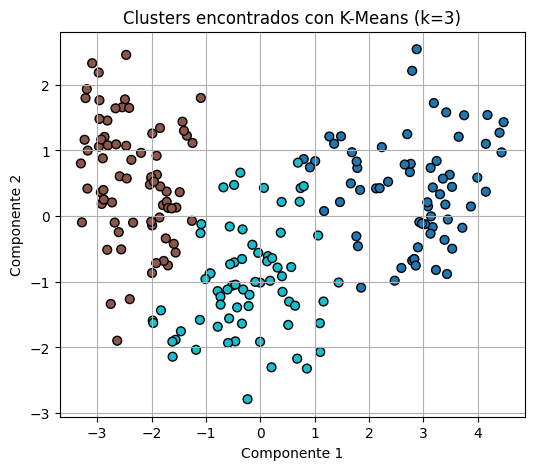

In [33]:
# Aplicar KMeans con k = 3
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
y_kmeans = kmeans.fit_predict(X_pca_std)

# Visualización
plt.figure(figsize=(6, 5))
plt.scatter(X_pca_std[:, 0], X_pca_std[:, 1], c=y_kmeans, cmap='tab10', s=40, edgecolor='k')
plt.title(f'Clusters encontrados con K-Means (k={k})')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.grid(True)
plt.show()

### Clustering con K-Means

Según el gráfico del método del codo, el valor más adecuado para `k` es 3. A partir de ese punto, la inercia (o suma de distancias internas a los clusters) ya no disminuye de forma significativa.

Con este valor, K-Means ha agrupado los datos en tres grupos diferentes. Aunque no hemos usado la clase real, visualmente se observa que las agrupaciones parecen tener cierta coherencia. Más adelante compararemos estas agrupaciones con las clases originales para ver si coinciden.


Aplicamos K-Means a los datos procesados con StandardScaler y PCA. Usamos el método del codo para determinar el valor más adecuado de `k`, y seleccionamos `k=3` porque la inercia deja de reducirse significativamente a partir de ahí.

El gráfico muestra cómo el algoritmo ha separado los puntos en tres grupos distintos. Esta agrupación no utiliza la clase real, y servirá como comparación con los otros métodos de clustering que aplicaremos después.

### Análisis de la varianza explicada por PCA

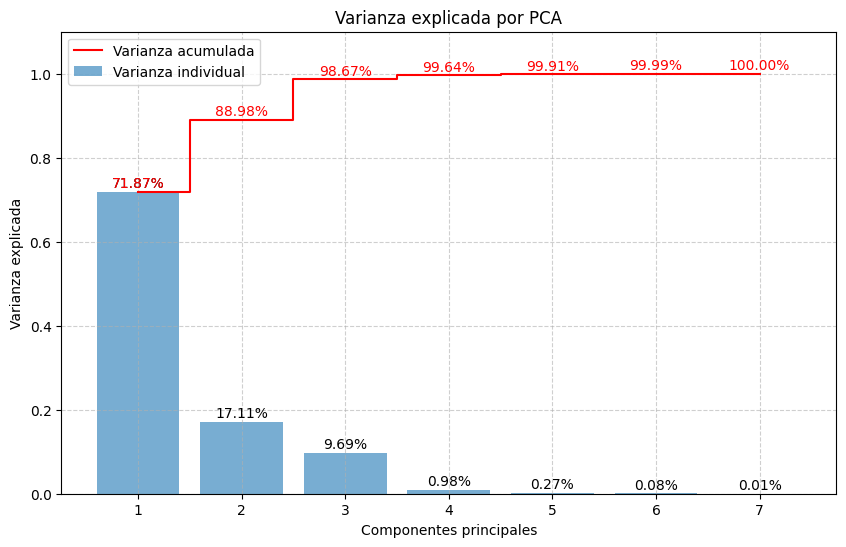

In [34]:
# Crear un pipeline con StandardScaler + PCA
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Siempre escalar antes de PCA
    ('pca', PCA())
])

# Ajustar y transformar los datos
X_reduced = pipeline.fit_transform(X)
pca = pipeline.named_steps['pca']

# Extraer varianza explicada
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Gráfico de varianza explicada
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, label='Varianza individual')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Varianza acumulada', color='red')

# Añadir etiquetas con valores
for i, (ev, cv) in enumerate(zip(explained_variance, cumulative_variance)):
    plt.text(i + 1, ev + 0.01, f"{ev:.2%}", ha='center')
    plt.text(i + 1, cv + 0.01, f"{cv:.2%}", ha='center', color='red')

plt.xlabel('Componentes principales')
plt.ylabel('Varianza explicada')
plt.title('Varianza explicada por PCA')
plt.legend(loc='best')
plt.ylim(0, 1.1)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Varianza explicada por PCA

En este gráfico analizamos cuánta varianza explica cada componente principal tras aplicar PCA a los datos escalados. Vemos que la **primera componente** ya explica cerca del **72% de la varianza**, y con solo **dos componentes** se alcanza casi un **89%**, lo cual es muy alto.

Esto justifica el uso de solo **dos dimensiones** para representar los datos posteriormente y aplicar clustering. Además, permite simplificar el problema sin perder información relevante.

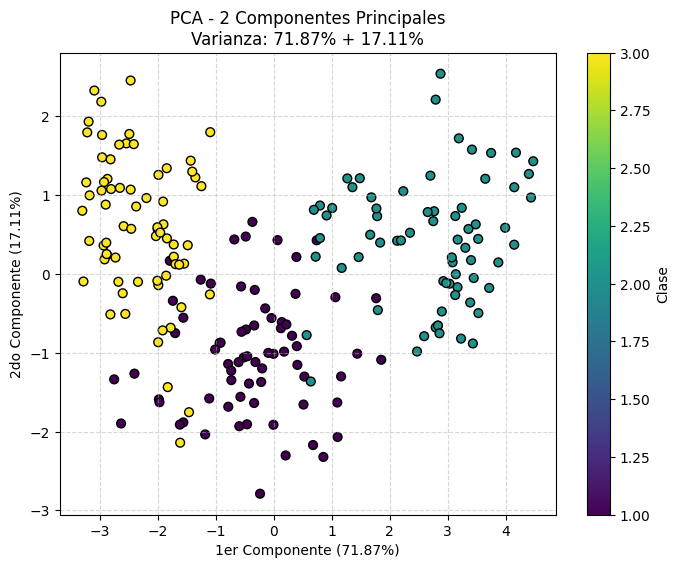

In [35]:
# PCA a 2 dimensiones
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2))
])

X_reduced_2D = pipeline.fit_transform(X)
pca_2d = pipeline.named_steps['pca']
explained_variance = pca_2d.explained_variance_ratio_

# Visualización en 2D con clases reales (solo como referencia visual)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_reduced_2D[:, 0], X_reduced_2D[:, 1],
    c=y, cmap='viridis', s=40, edgecolor='k'
)
plt.title(f'PCA - 2 Componentes Principales\nVarianza: {explained_variance[0]:.2%} + {explained_variance[1]:.2%}')
plt.xlabel(f'1er Componente ({explained_variance[0]:.2%})')
plt.ylabel(f'2do Componente ({explained_variance[1]:.2%})')
plt.colorbar(scatter, label='Clase')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## Aplicación de Técnicas de Clustering

Según el enunciado, debemos aplicar las tres técnicas de clustering explicadas en clase:
- K-Means
- Clustering Jerárquico (Dendrogramas)
- DBSCAN

### Clustering Jerárquico

Para el clustering jerárquico, seguiremos estos pasos:

1. Utilizaremos `AgglomerativeClustering` de scikit-learn para realizar el agrupamiento jerárquico

2. Visualizaremos el dendrograma utilizando las funciones de scipy para analizar cómo se agrupan los datos

3. Evaluaremos diferentes métodos de enlace (*linkage*):
   - Ward
   - Complete
   - Average

4. Determinaremos el número óptimo de clusters mediante inspección visual del dendrograma

5. Visualizaremos los grupos resultantes en el espacio PCA, de manera similar al análisis realizado con K-Means


### Celda 1 – Dendrograma con varios métodos de linkage

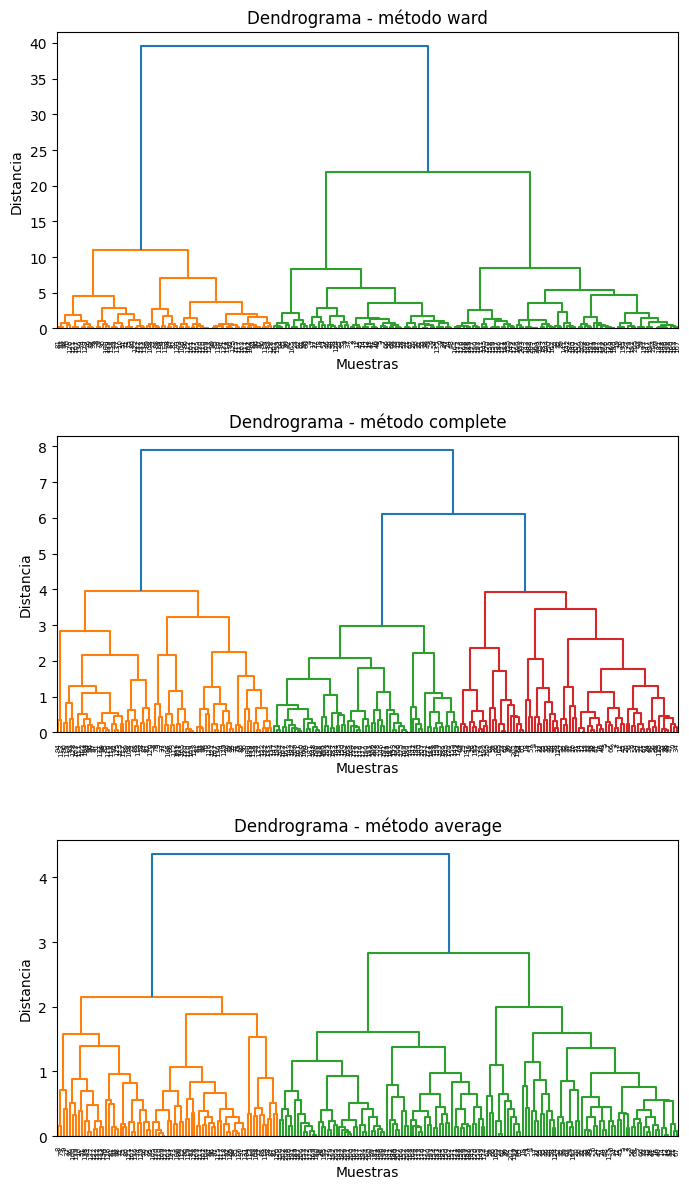

In [36]:
# Métodos de linkage que queremos comparar
linkage_methods = ['ward', 'complete', 'average']

# Ajustar tamaño para vista vertical clara
plt.figure(figsize=(7, 12))

for i, method in enumerate(linkage_methods):
    plt.subplot(3, 1, i + 1)
    sch.dendrogram(sch.linkage(X_pca_std, method=method))
    plt.title(f'Dendrograma - método {method}', fontsize=12)
    plt.xlabel('Muestras')
    plt.ylabel('Distancia')

plt.tight_layout(h_pad=3.0)  # separa verticalmente las subplots
plt.show()

### Celda 2 – Agrupamiento con AgglomerativeClustering

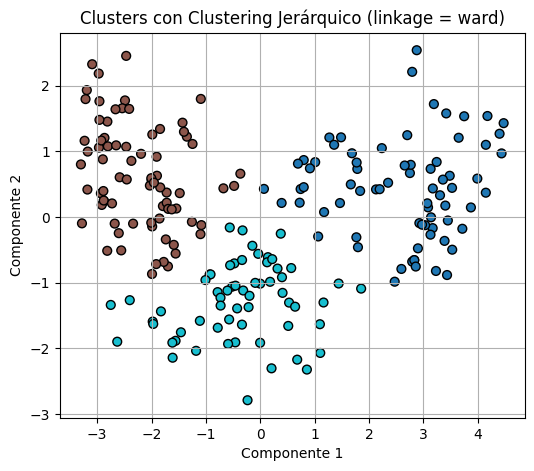

In [37]:
# Probamos con el método 'ward' y número de clusters = 3
hc = AgglomerativeClustering(n_clusters=3, linkage='ward')
y_hc = hc.fit_predict(X_pca_std)

# Visualizar los clusters encontrados
plt.figure(figsize=(6, 5))
plt.scatter(X_pca_std[:, 0], X_pca_std[:, 1], c=y_hc, cmap='tab10', s=40, edgecolor='k')
plt.title('Clusters con Clustering Jerárquico (linkage = ward)')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.grid(True)
plt.show()

### Clustering jerárquico (con dendrograma)

En esta sección aplicamos **clustering jerárquico aglomerativo** sobre los datos proyectados en 2D con PCA. Para ello, probamos tres métodos de enlace (`ward`, `complete`, `average`) y generamos sus respectivos dendrogramas.

- Con `ward`, se observan tres ramas principales claramente separadas, lo que sugiere cortar el árbol en **3 clusters**. La distancia entre estos grupos también es mayor, lo cual indica que están más definidos.
- `complete` y `average` también permiten distinguir una posible división en 3 clusters, aunque las separaciones no son tan limpias como en `ward`. Además, las distancias máximas son menores, lo que puede implicar menor contraste entre los grupos.

Tras observar los dendrogramas, decidimos continuar con `ward` y cortar en **3 grupos**.

El gráfico de dispersión muestra cómo se agruparon los puntos usando `AgglomerativeClustering` con `linkage='ward'` y `n_clusters=3`. A diferencia de K-Means, la forma de los clusters es más libre (no asume que tienen forma circular) y parece captar mejor algunos límites entre grupos.

En general, este método también ofrece una segmentación clara y servirá para compararla con DBSCAN más adelante.

los dendrogramas y el gráfico de clusters que has mostrado, puedo hacer el siguiente análisis:

1. Dendrograma con método Ward :
   
   - Muestra una estructura jerárquica muy clara
   - Se pueden identificar claramente 3 grupos principales
   - Las distancias entre clusters son bastante pronunciadas (notar la escala que llega hasta 40)
   - Este método parece ser el más adecuado para tus datos, ya que muestra una separación más clara
2. Dendrograma con método Complete :
   
   - También muestra una estructura de 3-4 clusters principales
   - Las distancias son menores (escala hasta 8)
   - La estructura es menos balanceada que con Ward
   - Los clusters parecen estar más dispersos
3. Dendrograma con método Average :
   
   - Muestra una estructura similar pero con distancias aún más pequeñas (escala hasta 4)
   - La separación entre clusters es menos pronunciada
   - Las agrupaciones son más graduales
4. Gráfico de Clusters resultante (usando Ward) :
   
   - Se observan 3 clusters bien definidos y separados
   - Los clusters tienen formas coherentes y están bien distribuidos en el espacio
   - Hay una clara separación espacial entre los grupos
   - Los colores (marrón, azul claro y azul oscuro) muestran una buena segmentación
En conclusión:

- La implementación está muy bien hecha
- El método Ward parece ser el más apropiado para tus datos, ya que:
  - Muestra clusters más balanceados
  - Tiene una separación más clara entre grupos
  - El gráfico de dispersión confirma que los clusters tienen sentido espacialmente
- El número óptimo de clusters parece ser 3, basándose en los cortes naturales que se observan en los dendrogramas y en la visualización final

## En el último método de clustering: DBSCAN, que es distinto a los anteriores porque:

- No necesitas decir cuántos clusters hay.

- Detecta automáticamente grupos según la densidad de puntos.

- Marca los puntos "solitarios" como ruido (outliers).

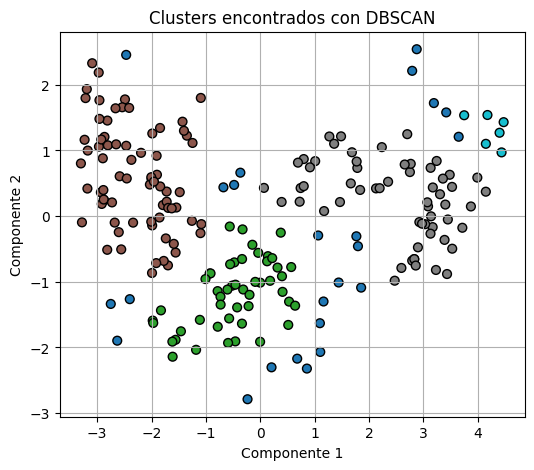

In [38]:
# Probar DBSCAN sobre los datos PCA
# Probar varios valores para eps y min_samples es importante
dbscan = DBSCAN(eps=0.5, min_samples=5)
y_dbscan = dbscan.fit_predict(X_pca_std)

# Visualizar los clusters detectados
plt.figure(figsize=(6, 5))
plt.scatter(X_pca_std[:, 0], X_pca_std[:, 1], c=y_dbscan, cmap='tab10', s=40, edgecolor='k')
plt.title('Clusters encontrados con DBSCAN')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.grid(True)
plt.show()

#### Cuenta cuántos clusters ha encontrado DBSCAN (sin contar el -1).

In [39]:
clusters_dbscan = np.unique(y_dbscan)
print("Etiquetas encontradas por DBSCAN:", clusters_dbscan)
print("Número de clusters (excluyendo ruido):", len(clusters_dbscan[clusters_dbscan != -1]))
print("Número de puntos considerados ruido:", np.sum(y_dbscan == -1))

Etiquetas encontradas por DBSCAN: [-1  0  1  2  3]
Número de clusters (excluyendo ruido): 4
Número de puntos considerados ruido: 24


### Clustering con DBSCAN

Aplicamos DBSCAN sobre los datos reducidos a dos dimensiones con PCA. Este algoritmo no necesita que le indiquemos el número de clusters, sino que agrupa los puntos en función de su densidad local, según los parámetros `eps` y `min_samples`.

Con `eps=0.5` y `min_samples=5`, DBSCAN encontró **4 clusters** (sin contar los puntos considerados como ruido), y detectó **24 puntos** que no fueron asignados a ningún grupo (etiquetados como `-1`).

Estos puntos de ruido pueden interpretarse como valores atípicos o simplemente como datos que no encajan bien en los patrones principales. En la visualización se ve cómo los clusters tienen formas menos regulares que en K-Means, y cómo el algoritmo consigue separar zonas densas sin asumir que los grupos tienen una forma circular.

Este enfoque resulta especialmente útil en problemas donde los datos están distribuidos de forma desigual o con bordes difusos.

### Comparación visual entre clases reales y clustering

En esta figura comparamos la distribución de las clases reales (columna "clase") con los clusters encontrados por K-Means, clustering jerárquico y DBSCAN.

A simple vista, **K-Means y el clustering jerárquico** se aproximan bastante bien a la distribución real, formando tres grupos que más o menos coinciden con las clases. En cambio, **DBSCAN** detecta cuatro grupos y deja varios puntos fuera (como ruido), por lo que la separación no coincide tan bien.

Este análisis visual nos ayuda a entender cuál de los métodos ha logrado una agrupación más coherente respecto a las clases originales, aunque debemos recordar que el clustering es no supervisado y no utiliza esa información en su entrenamiento.

### 1 -Visualizar clusters vs clases reales

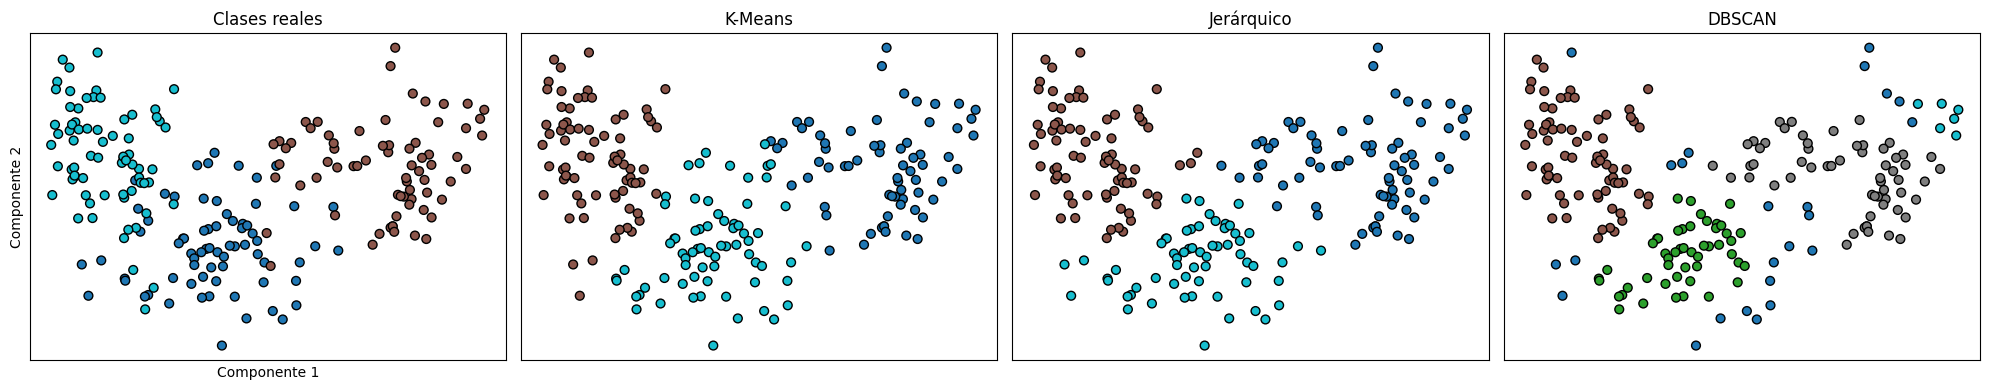

In [40]:
# Vamos a dibujar los datos en 2D coloreando por la clase real y luego uno al lado de otro con los resultados de K-Means, Jerárquico y DBSCAN.

fig, axs = plt.subplots(1, 4, figsize=(20, 4))

# Clases reales
axs[0].scatter(X_pca_std[:, 0], X_pca_std[:, 1], c=y, cmap='tab10', s=40, edgecolor='k')
axs[0].set_title('Clases reales')
axs[0].set_xlabel('Componente 1')
axs[0].set_ylabel('Componente 2')

# K-Means
axs[1].scatter(X_pca_std[:, 0], X_pca_std[:, 1], c=y_kmeans, cmap='tab10', s=40, edgecolor='k')
axs[1].set_title('K-Means')

# Jerárquico
axs[2].scatter(X_pca_std[:, 0], X_pca_std[:, 1], c=y_hc, cmap='tab10', s=40, edgecolor='k')
axs[2].set_title('Jerárquico')

# DBSCAN
axs[3].scatter(X_pca_std[:, 0], X_pca_std[:, 1], c=y_dbscan, cmap='tab10', s=40, edgecolor='k')
axs[3].set_title('DBSCAN')

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

### Comparación visual entre clases reales y resultados de clustering

En esta figura se comparan los resultados de los tres algoritmos de clustering aplicados (K-Means, Jerárquico y DBSCAN) con las clases reales del dataset (`clase`). Aunque ninguno de los modelos usó esta información durante el entrenamiento, la visualización nos permite comprobar qué tan bien coinciden los grupos encontrados con las categorías verdaderas.

- **K-Means** y **Jerárquico (ward)** ofrecen resultados bastante parecidos. Ambos consiguen formar tres grupos bien definidos que, visualmente, se alinean de forma bastante coherente con las clases originales.
- **DBSCAN**, en cambio, detecta cuatro grupos y marca muchos puntos como ruido (`-1`, en gris). Aunque es útil para encontrar estructuras más complejas o detectar outliers, en este caso su agrupamiento no coincide tan claramente con las clases reales.

Esta comparación visual es útil para evaluar, aunque de forma cualitativa, cuál de los algoritmos se ha aproximado más a la estructura real del problema.

### Vamos a volver a cargar los datos con nombres,y crear boxplots para interpretar los clusters

<ipython-input-41-fe76de43d2b9>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='cluster_kmeans', y=col, palette='Set2')
<ipython-input-41-fe76de43d2b9>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='cluster_kmeans', y=col, palette='Set2')
<ipython-input-41-fe76de43d2b9>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='cluster_kmeans', y=col, palette='Set2')
<ipython-input-41-fe76de43d2b9>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assi

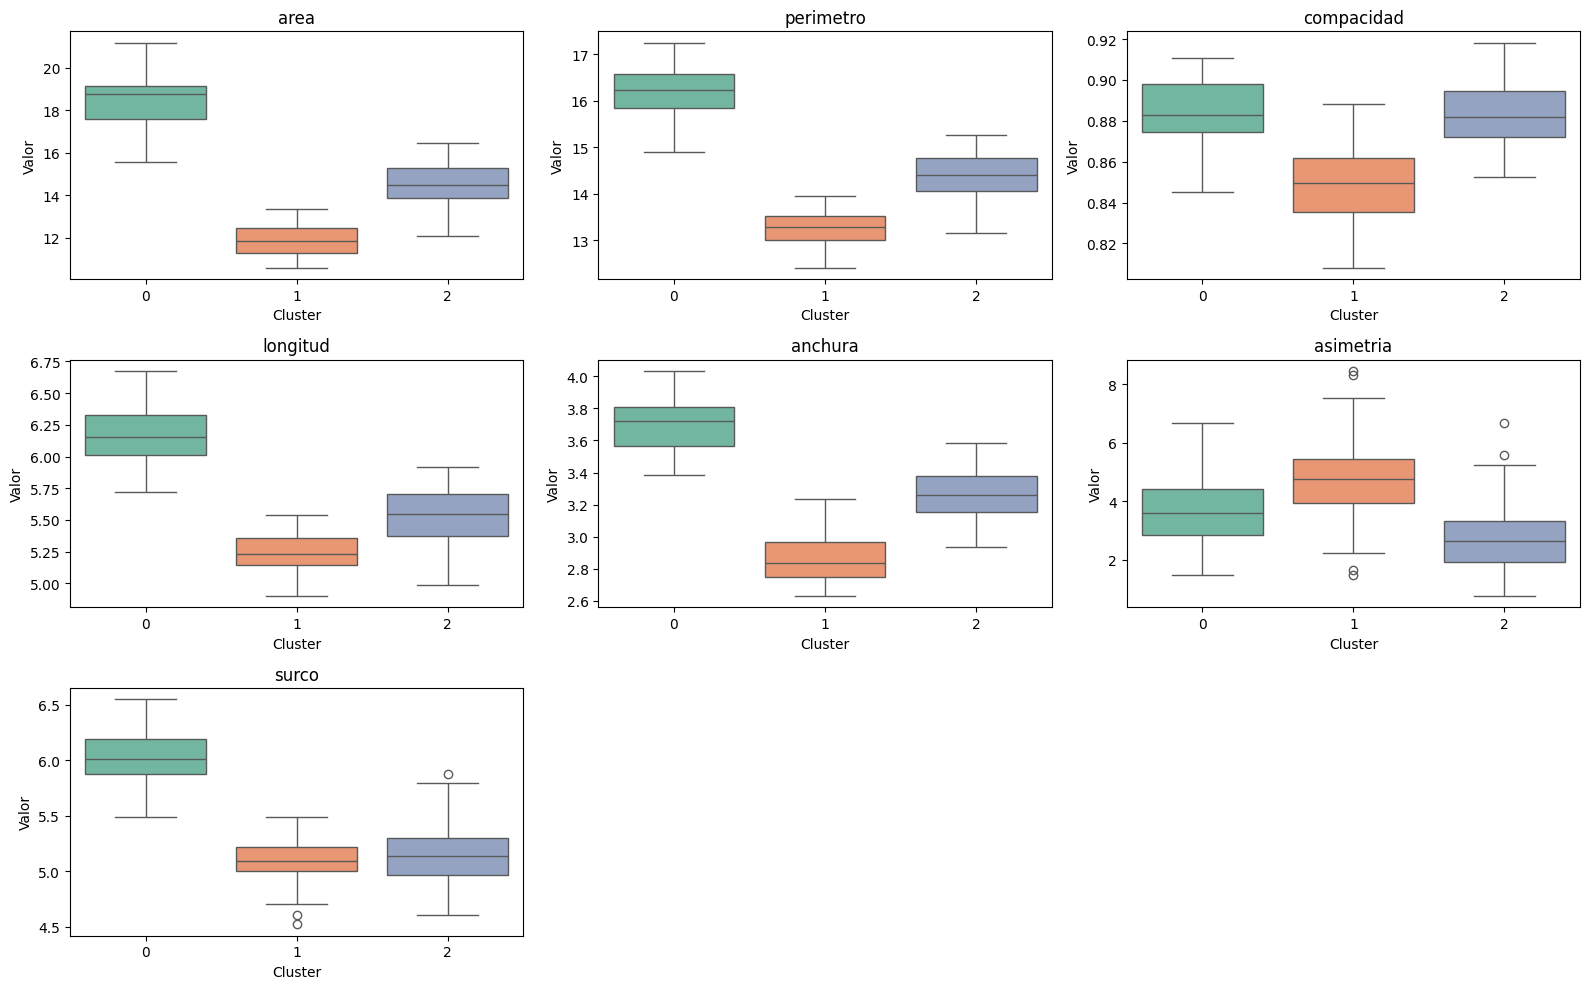

In [41]:
# Volver a cargar el dataframe con nombres de columnas
df = pd.read_csv('/content/semillas.csv')

# Añadir los clusters de K-Means como columna
df['cluster_kmeans'] = y_kmeans

# Lista de variables a comparar (excluimos 'clase' y 'cluster_kmeans')
features = df.columns[:-2]

# Creamos un gráfico por variable
plt.figure(figsize=(16, 10))

for i, col in enumerate(features):
    plt.subplot(3, 3, i+1)
    sns.boxplot(data=df, x='cluster_kmeans', y=col, palette='Set2')
    plt.title(col)
    plt.xlabel('Cluster')
    plt.ylabel('Valor')

plt.tight_layout()
plt.show()

In [42]:
# Crear un DataFrame largo para los boxplots con hue
# Cargar nuevamente si hace falta
df = pd.read_csv('/content/semillas.csv')
df['KMeans'] = y_kmeans
df['Jerarquico'] = y_hc
df['DBSCAN'] = y_dbscan
df['ClaseOriginal'] = y  # la clase real

# Guardamos las columnas de atributos
atributos = ['area', 'perimetro', 'compacidad', 'longitud', 'anchura', 'asimetria', 'surco']

# Creamos listas para convertir a formato largo
dfs_largos = []

for nombre_grupo in ['ClaseOriginal', 'KMeans', 'Jerarquico', 'DBSCAN']:
    df_temp = df[atributos].copy()
    df_temp['grupo'] = df[nombre_grupo]
    df_temp['agrupamiento'] = nombre_grupo
    dfs_largos.append(df_temp)

# Concatenamos todo en un solo DataFrame largo
df_largo = pd.concat(dfs_largos)

# Lo dejamos en formato largo con melt para Seaborn
df_largo = pd.melt(df_largo, id_vars=['agrupamiento', 'grupo'], value_vars=atributos,
                   var_name='variable', value_name='valor')

In [43]:
df_largo

,agrupamiento,grupo,variable,valor
0,ClaseOriginal,1,area,15.260
1,ClaseOriginal,1,area,14.880
2,ClaseOriginal,1,area,14.290
3,ClaseOriginal,1,area,13.840
4,ClaseOriginal,1,area,16.140
...,...,...,...,...
5875,DBSCAN,1,surco,4.870
5876,DBSCAN,1,surco,5.003
5877,DBSCAN,1,surco,5.056
5878,DBSCAN,1,surco,5.044


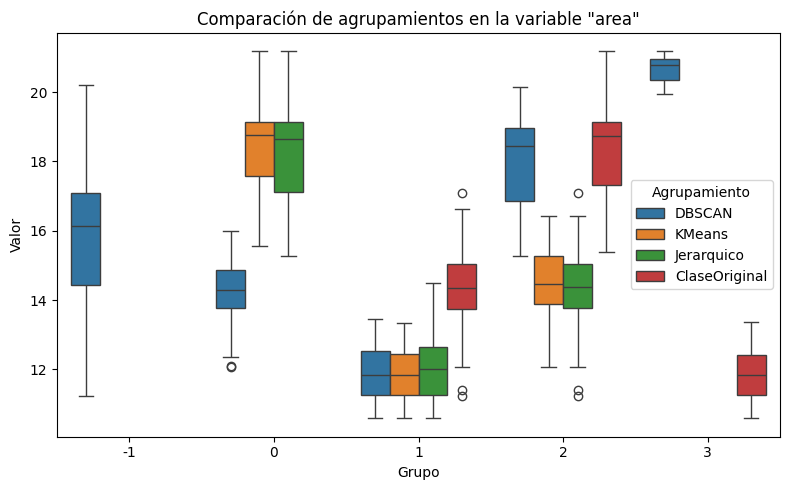

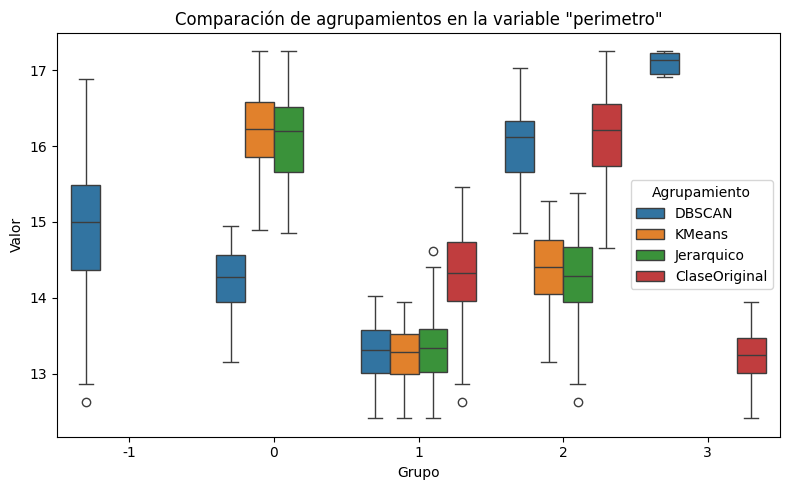

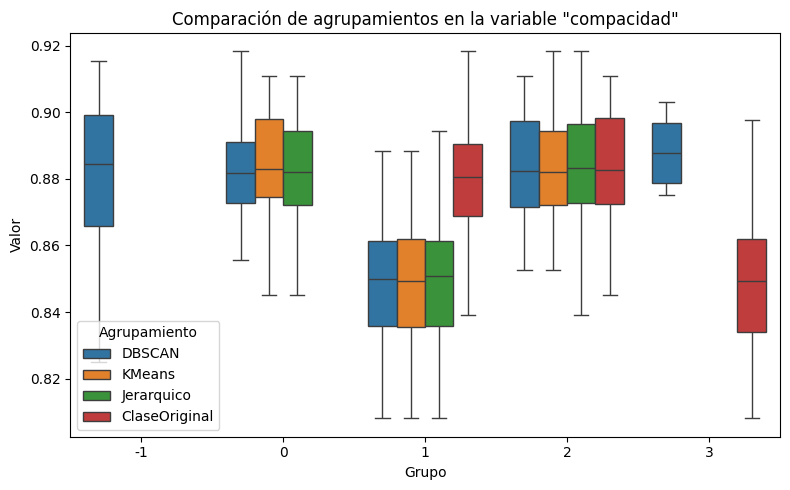

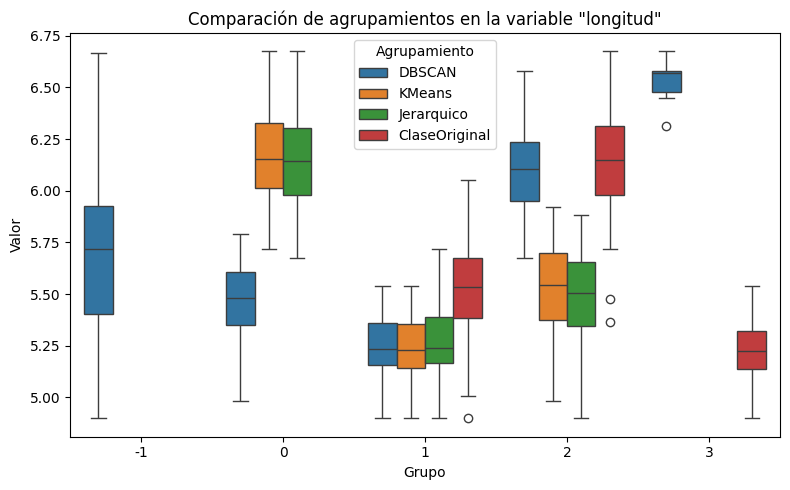

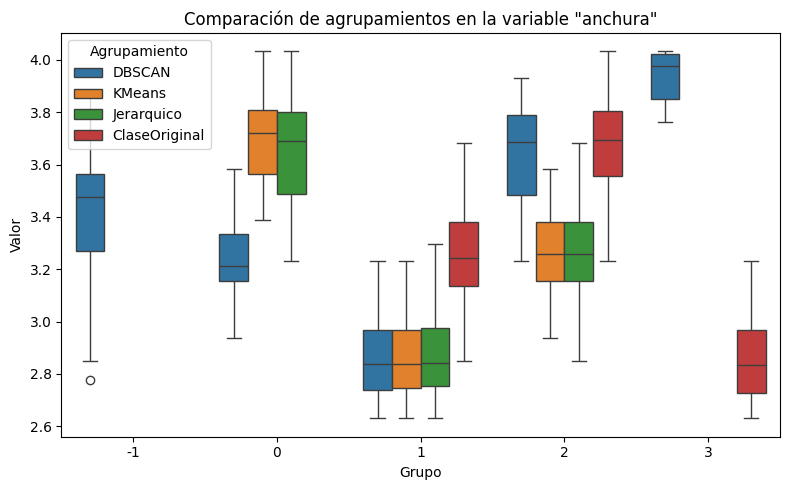

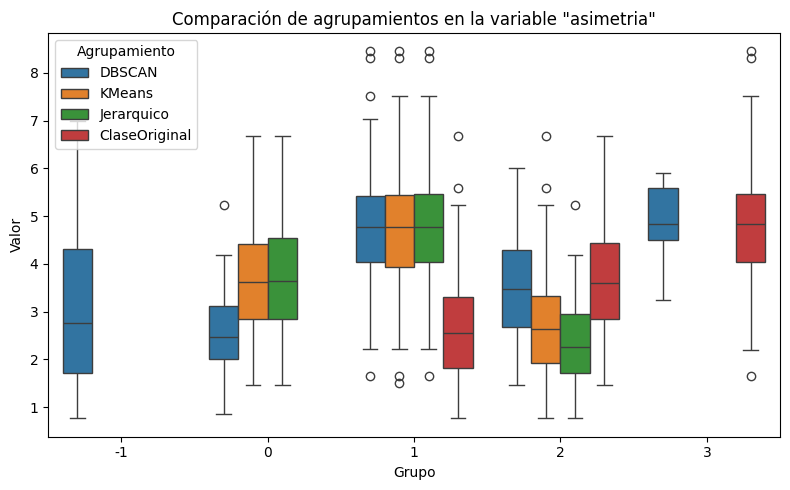

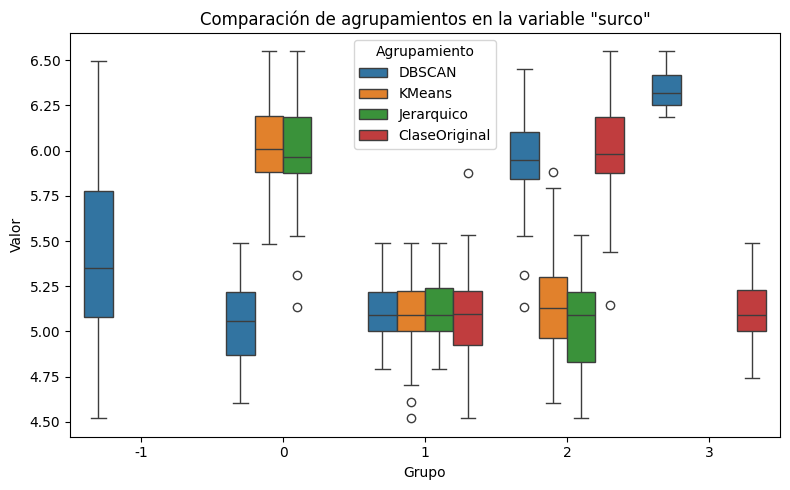

In [44]:
# Obtener todas las variables (las columnas originales del dataset)
variables = df_largo['variable'].unique()

# Crear una figura para cada variable
for var in variables:
    plt.figure(figsize=(8, 5))
    sns.boxplot(
        data=df_largo[df_largo['variable'] == var],
        x='grupo', y='valor', hue='agrupamiento'
    )
    plt.title(f'Comparación de agrupamientos en la variable "{var}"')
    plt.xlabel('Grupo')
    plt.ylabel('Valor')
    plt.legend(title='Agrupamiento')
    plt.tight_layout()
    plt.show()

### Comparación global de agrupamientos mediante boxplots con `hue`

Este gráfico resume de forma visual cómo se distribuyen las variables originales de las semillas dentro de los grupos creados por los distintos métodos de agrupamiento: **K-Means**, **clustering jerárquico**, **DBSCAN** y también por la **clase real** (`ClaseOriginal`).

Gracias al uso del parámetro `hue`, podemos ver para cada grupo (por ejemplo el grupo 0) cómo varía cada variable dependiendo del tipo de agrupamiento.

Algunas observaciones clave:
- Los métodos **K-Means** y **Jerárquico** tienden a mostrar distribuciones bastante parecidas entre sí, especialmente en variables como `área` o `longitud`.
- **DBSCAN** muestra más dispersión en algunos casos, y también incluye el grupo `-1` que representa puntos considerados como ruido.
- La **clase original** se distingue por tener una segmentación más consistente en ciertas variables (como `surco`), aunque no siempre es la más diferenciada.

Este tipo de gráfico es útil para **ver en una sola visualización qué método de clustering se acerca más al comportamiento real de los datos**, y qué tan coherentes son las agrupaciones según las variables originales.

### Análisis de los clusters con boxplots (K-Means)

En esta figura analizamos cómo se comportan los valores originales de las semillas dentro de cada uno de los tres clusters detectados por K-Means.

Podemos observar diferencias claras entre los grupos:

- El **cluster 0** agrupa semillas con valores altos en casi todas las variables: área, perímetro, longitud, anchura y surco. Esto podría corresponder a una clase de semillas de mayor tamaño.
- El **cluster 1**, por el contrario, muestra los valores más bajos en todas esas características, además de mayor asimetría. Esto sugiere que este grupo contiene las semillas más pequeñas o menos simétricas del conjunto.
- El **cluster 2** tiene valores intermedios. Destaca por una **compacidad** algo mayor que la del cluster 1, y por tener menor asimetría que ambos clusters anteriores.

Este tipo de visualización nos ayuda a interpretar los grupos más allá de sus posiciones en el espacio PCA. Ahora entendemos mejor qué variables son las que están separando los datos y cómo se podrían describir los clusters con palabras, algo muy útil si quisiéramos dar sentido práctico a estas agrupaciones.

### Vamos a repetir el análisis de los boxplots, esta vez con los clusters obtenidos por el algoritmo jerárquico (AgglomerativeClustering).



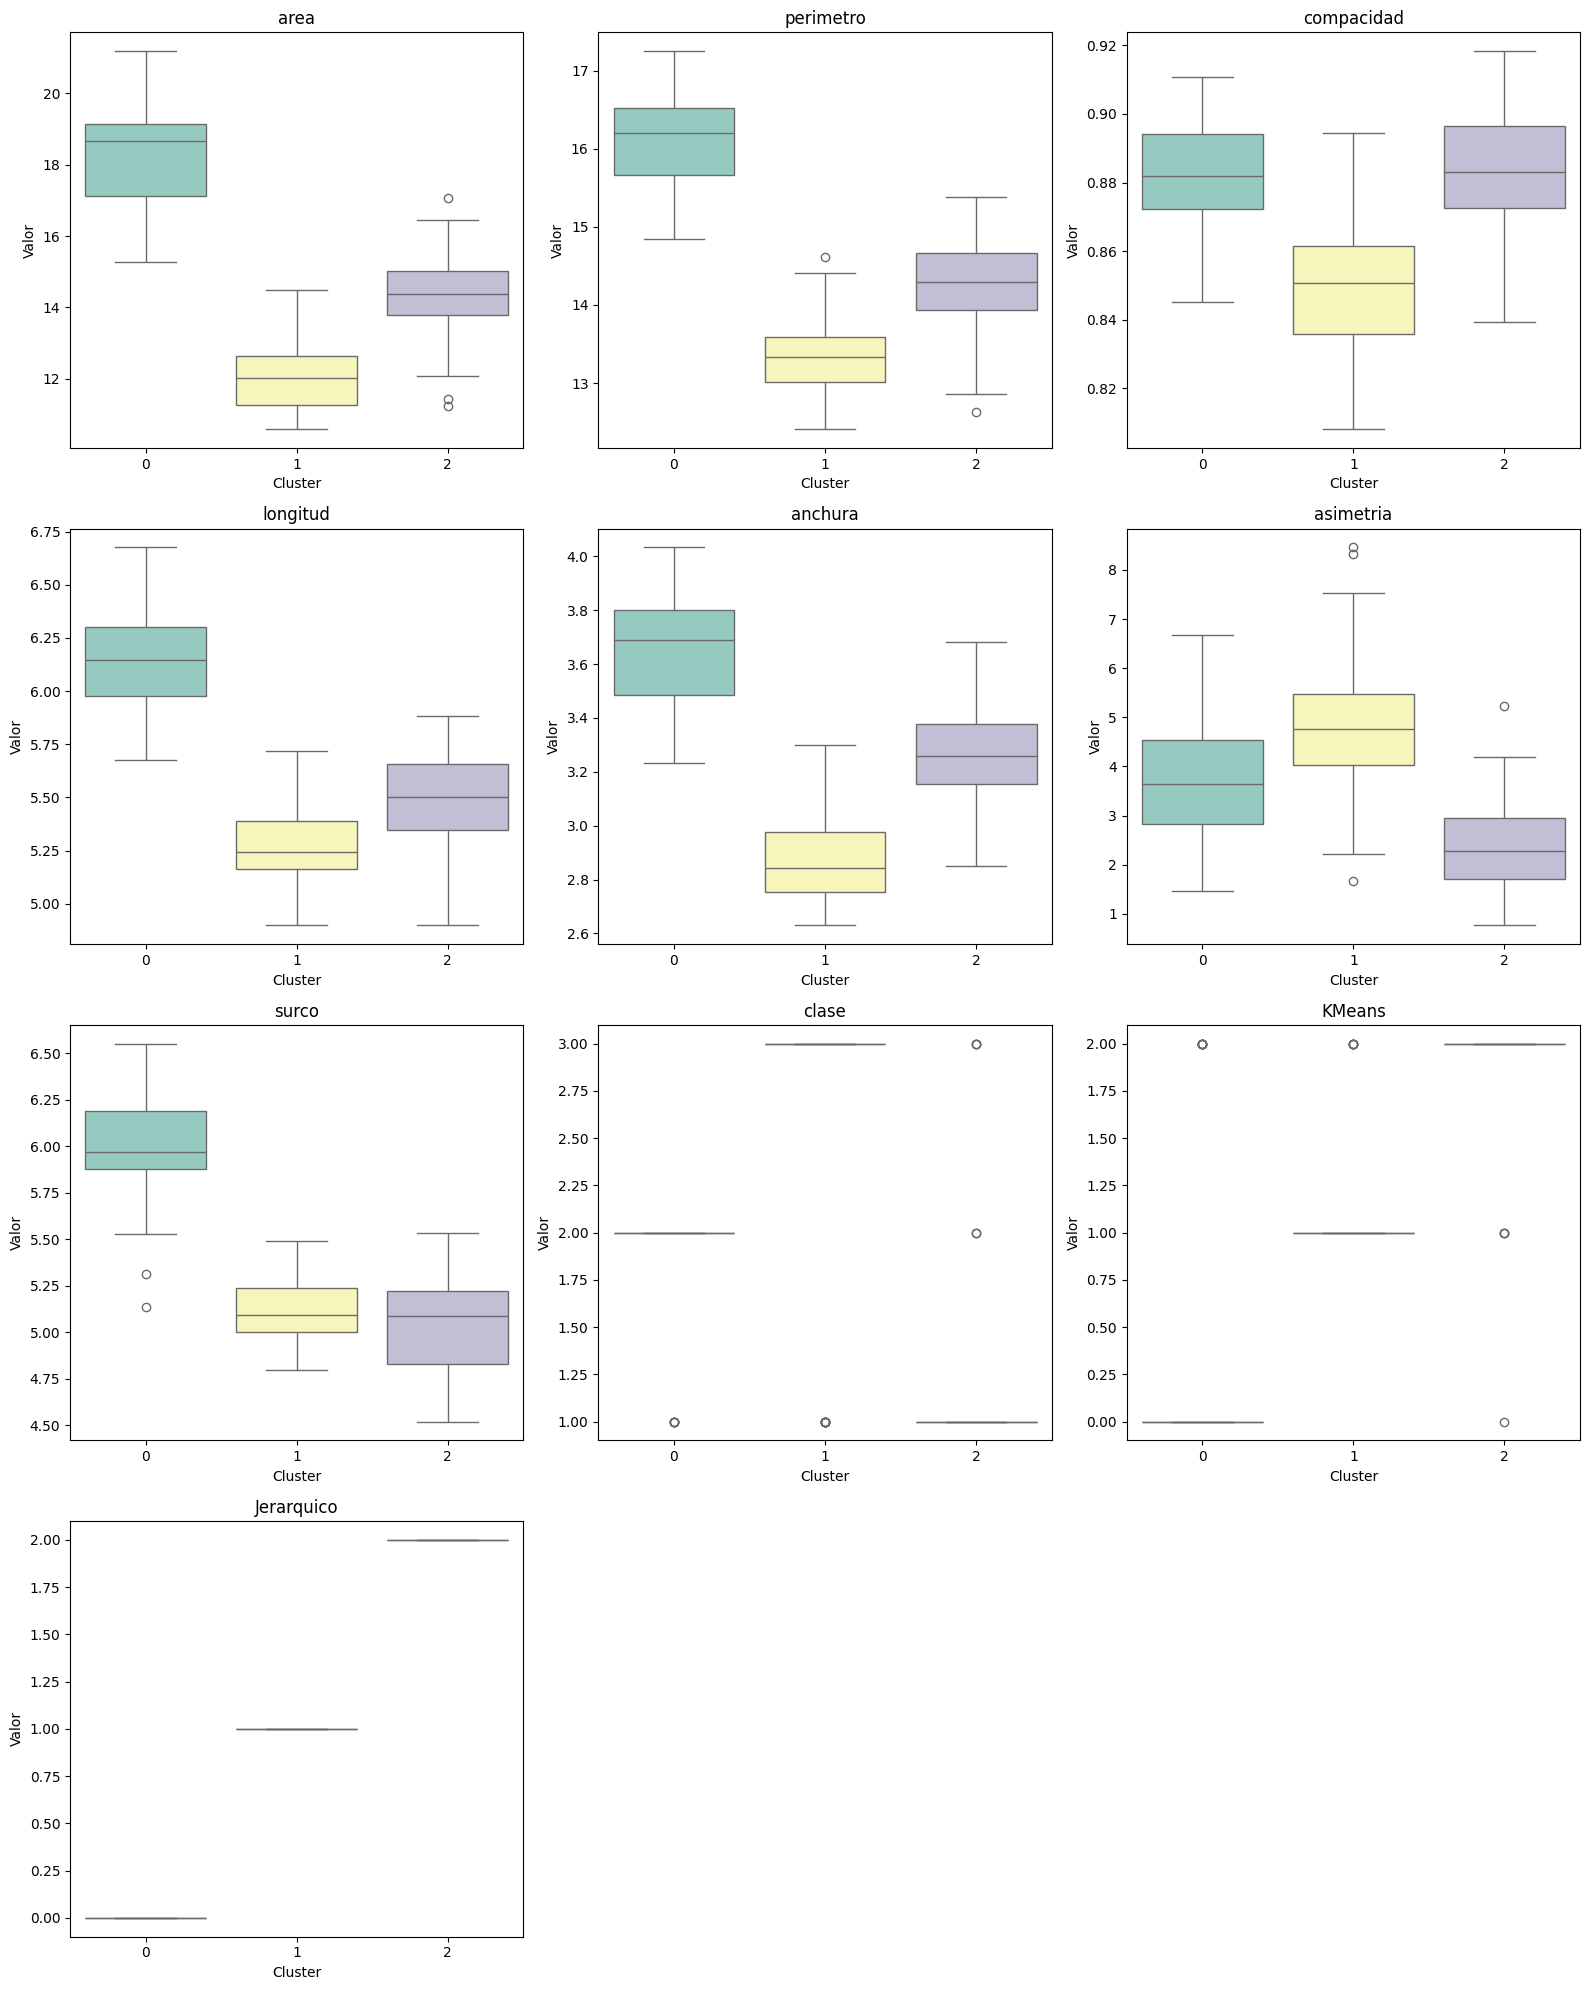

In [45]:
# Añadir los clusters jerárquicos al DataFrame
df['cluster_hc'] = y_hc

# Dibujar boxplots por variable para clusters jerárquicos
features = df.columns[:-3]  # excluye 'clase', 'cluster_kmeans' y 'cluster_hc'

# Calcular el número de filas necesarias para mostrar todas las características
n_features = len(features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols  # Redondeo hacia arriba

plt.figure(figsize=(16, 5*n_rows))

for i, col in enumerate(features):
    plt.subplot(n_rows, n_cols, i+1)
    sns.boxplot(data=df, x='cluster_hc', y=col, hue='cluster_hc', palette='Set3', legend=False)
    plt.title(col)
    plt.xlabel('Cluster')
    plt.ylabel('Valor')

plt.tight_layout()
plt.show()

### Análisis de los clusters con boxplots (Clustering Jerárquico)

Este análisis muestra cómo se comportan los valores originales de las semillas dentro de cada uno de los clusters detectados mediante clustering jerárquico (linkage='ward').

Al igual que con K-Means, se observan patrones consistentes:

- El **cluster 0** agrupa semillas grandes, con valores altos en área, perímetro, longitud, anchura y surco.
- El **cluster 1** tiene los valores más bajos en la mayoría de las variables, especialmente en área y compacidad, pero con mayor asimetría. Es decir, parece un grupo de semillas pequeñas y más irregulares.
- El **cluster 2** representa un grupo intermedio en muchas variables, pero destaca por tener la compacidad más alta y baja asimetría.

Los resultados refuerzan la idea de que el agrupamiento jerárquico ha captado una estructura coherente y parecida a la encontrada por K-Means. En ambos casos, los grupos tienen sentido si observamos las características físicas de las semillas.

Vamos con el análisis de boxplots para DBSCAN, teniendo en cuenta que este algoritmo:

Puede asignar la etiqueta -1 a los puntos que considera ruido.

En este análisis, podemos:

Incluir los -1 para ver cómo se comportan.

O bien excluir el ruido y analizar solo los clusters "válidos".

Vamos a hacer lo segundo (más limpio): analizar solo los puntos que no son ruido.

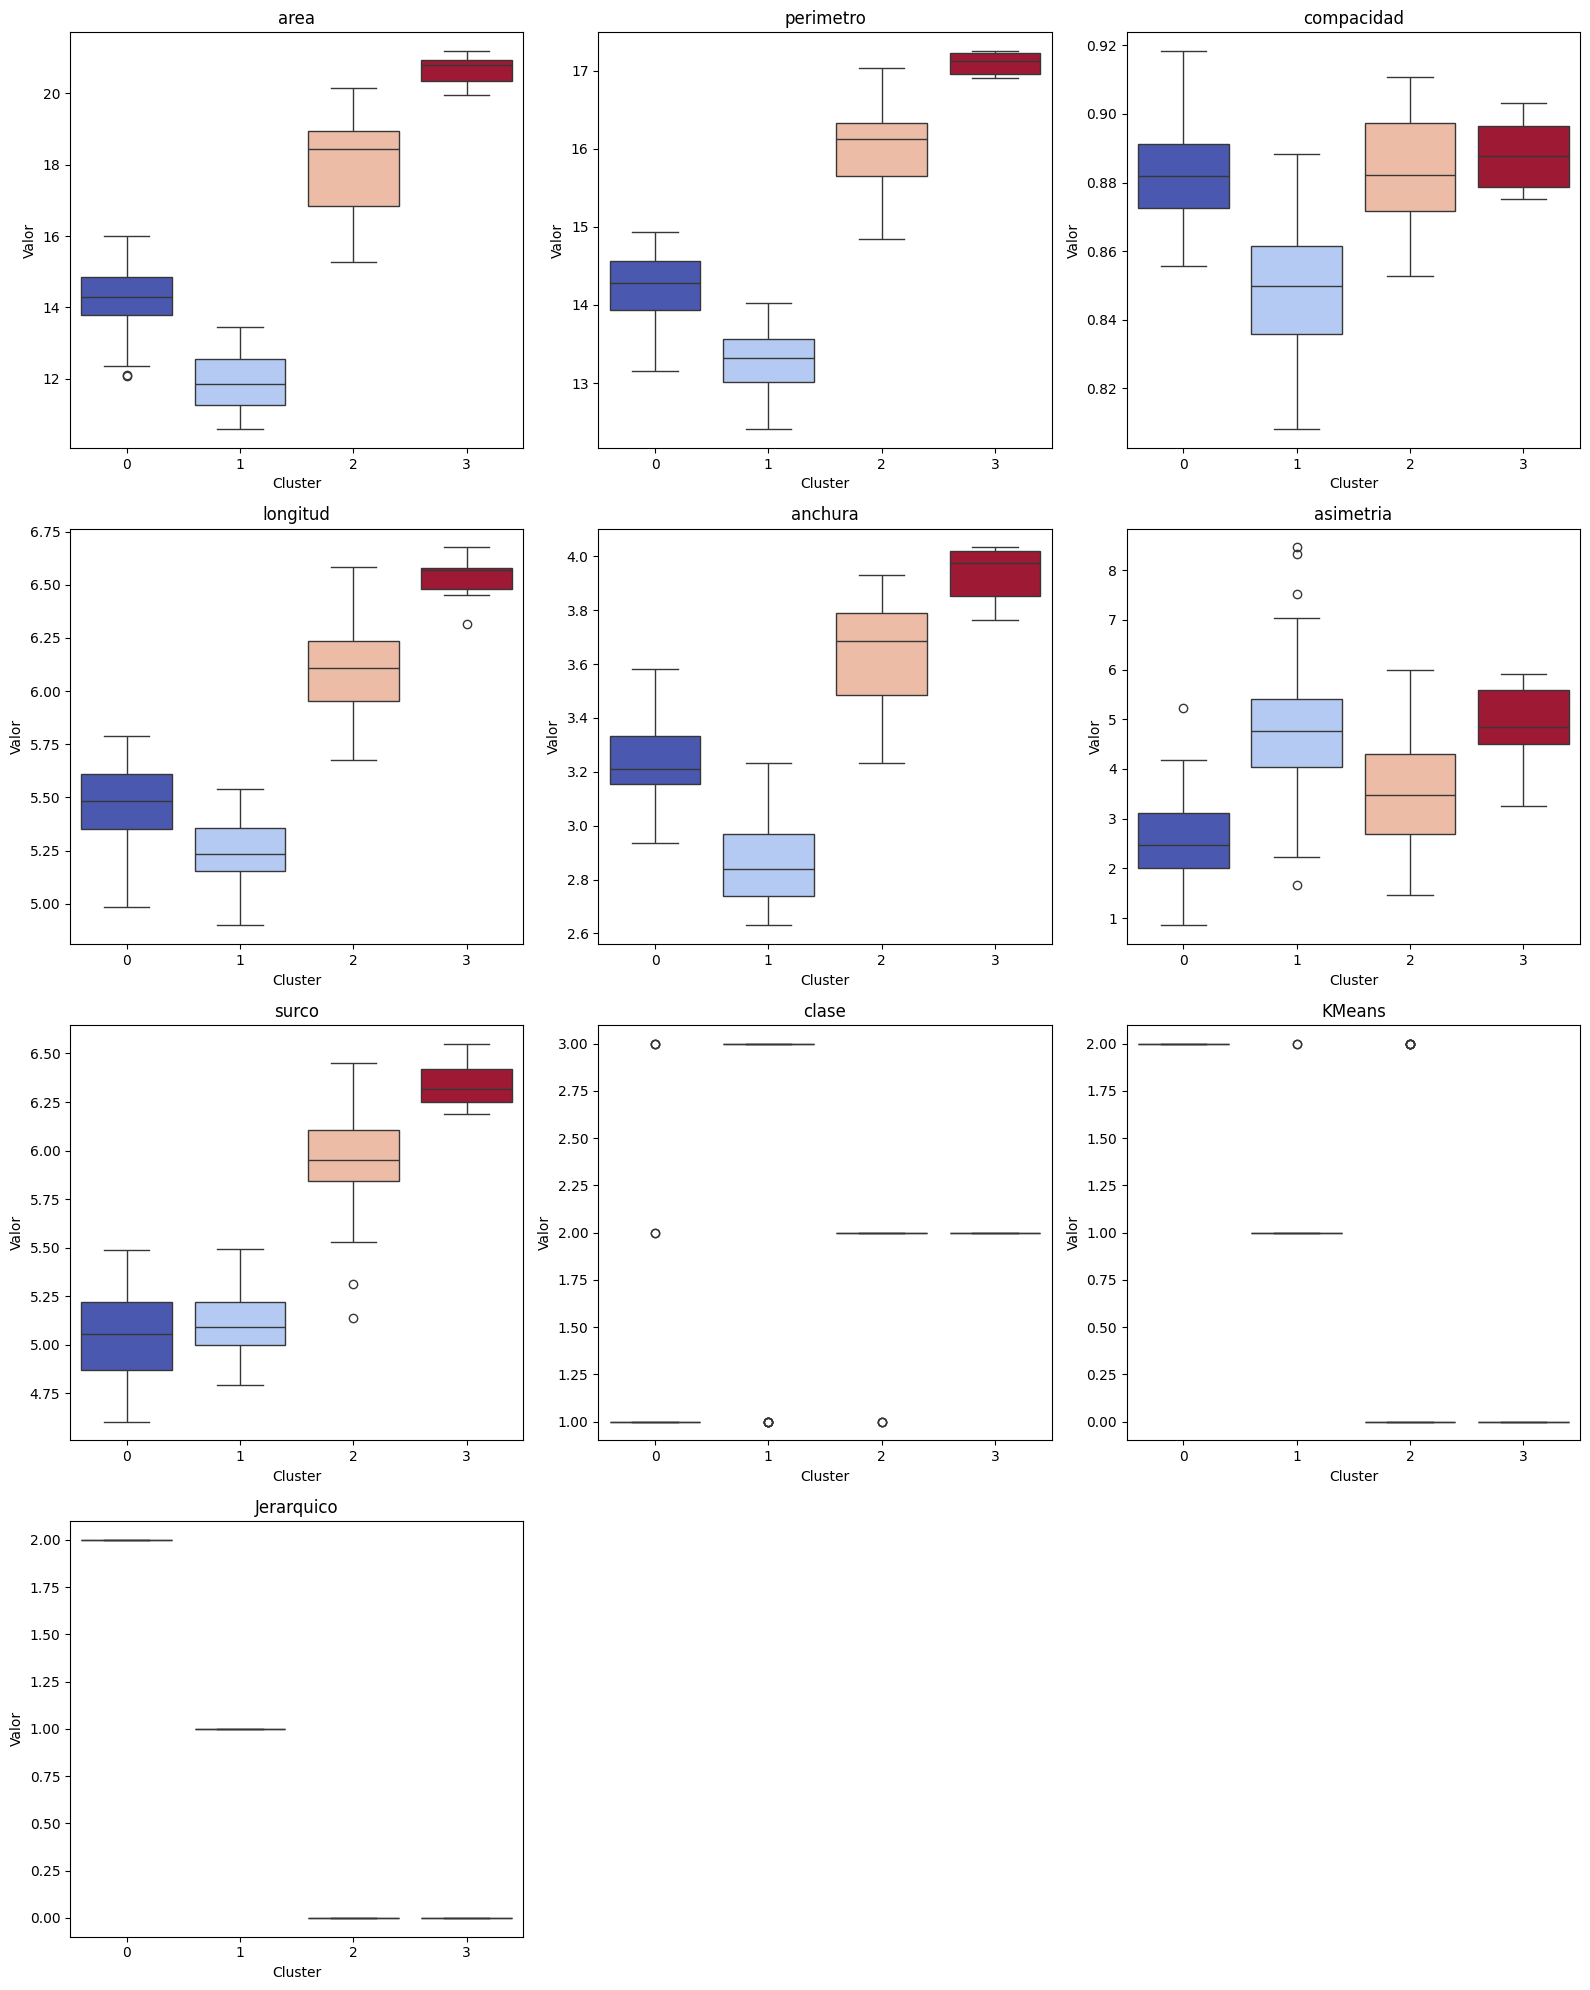

In [46]:
# Añadir etiquetas de DBSCAN
df['cluster_dbscan'] = y_dbscan

# Filtrar solo los puntos que no son ruido
df_dbscan_clean = df[df['cluster_dbscan'] != -1]

# Calcular el número de filas necesarias para mostrar todas las características
features = df.columns[:-4]  # excluye 'clase', 'cluster_kmeans', 'cluster_hc', 'cluster_dbscan'
n_features = len(features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols  # Redondeo hacia arriba

plt.figure(figsize=(16, 5*n_rows))

for i, col in enumerate(features):
    plt.subplot(n_rows, n_cols, i+1)
    sns.boxplot(data=df_dbscan_clean, x='cluster_dbscan', y=col,
                hue='cluster_dbscan', palette='coolwarm', legend=False)
    plt.title(col)
    plt.xlabel('Cluster')
    plt.ylabel('Valor')

plt.tight_layout()
plt.show()

### Análisis de los clusters con boxplots (DBSCAN)

En esta visualización analizamos los valores de las variables originales en los clusters encontrados por DBSCAN, excluyendo los puntos identificados como ruido (`-1`).

DBSCAN ha detectado **cuatro clusters distintos**, y los boxplots muestran diferencias claras entre ellos:

- El **cluster 3** agrupa semillas con los valores más altos en casi todas las variables: área, perímetro, longitud, anchura y surco. Parece ser el grupo más extremo, posiblemente correspondiente a semillas más grandes y homogéneas.
- El **cluster 1** contiene semillas con valores bajos y mayor variabilidad en compacidad y asimetría, lo que podría representar un grupo de semillas pequeñas o irregulares.
- El **cluster 0** tiene valores moderados, pero menos extremos que los anteriores, y una asimetría más baja.
- El **cluster 2** se encuentra entre los extremos, con valores intermedios y un perfil equilibrado en longitud y anchura.

Este análisis muestra que DBSCAN ha sido capaz de identificar subgrupos que no son tan evidentes en métodos como K-Means o Jerárquico. Además, al permitir formas más libres en los clusters y detectar outliers, proporciona un enfoque complementario y muy útil para entender la estructura interna del dataset.

### Conclusión final

A lo largo de esta práctica hemos aplicado tres técnicas distintas de agrupamiento no supervisado (K-Means, Clustering Jerárquico y DBSCAN) sobre un conjunto de datos con características de semillas. Antes de ello, preprocesamos los datos con distintos escaladores y redujimos la dimensionalidad usando PCA para facilitar la visualización.

#### K-Means:
Fue el más sencillo de ajustar (bastaba con elegir el número de clusters con el método del codo) y ofreció agrupaciones bastante limpias. Visualmente, los clusters se alineaban bien con las clases reales. Además, los boxplots mostraron diferencias claras entre los grupos, especialmente en tamaño y forma de las semillas.

#### Clustering jerárquico:
Ofreció resultados muy similares a los de K-Means, tanto en la visualización como en la interpretación con boxplots. Usando el método de enlace `ward`, el dendrograma mostró tres divisiones bastante claras. Este método permite explorar cómo se forman los clusters progresivamente, lo cual es útil para entender la estructura interna del dataset.

#### DBSCAN:
Fue el más distinto. No necesita especificar el número de clusters, sino que detecta grupos densos y marca como ruido los puntos que no se ajustan. En este caso, encontró cuatro clusters y detectó varios outliers. Aunque su segmentación no coincidía con las clases reales tan claramente, permitió detectar subgrupos más específicos y valores atípicos. Sus clusters fueron también bastante interpretables mediante boxplots.

---

En resumen, **K-Means y el clustering jerárquico** ofrecieron los resultados más cercanos a las clases originales, mientras que **DBSCAN aportó una visión complementaria**, descubriendo formas más irregulares y detectando ruido. Cada método tiene sus ventajas según el contexto, y combinarlos aporta una visión más completa del problema.